Занятие 6. Линейная регрессия
===========

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [5]:
import os

os.chdir("C:/Users/USER/Documents/Python/_AD_Python_part_1_Lectures/AD_Python_1_05_regression")


### Предсказание цен домов в Альбукерке

In [6]:
#  Новый вариант разделителя столбцов!

df = pd.read_csv('Albuquerque Home Prices.txt', sep='\t')
df.head()

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13,7,1,1,0,1639
1,2080,2600,-9999,4,1,1,0,1088
2,2150,2664,6,5,1,1,0,1193
3,2150,2921,3,6,1,1,0,1635
4,1999,2580,4,4,1,1,0,1732


In [7]:
#  В данных -9999 обозначает пропуски
df = df.replace(-9999, np.nan)
df.head()

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13.0,7,1,1,0,1639.0
1,2080,2600,NaN,4,1,1,0,1088.0
2,2150,2664,6.0,5,1,1,0,1193.0
3,2150,2921,3.0,6,1,1,0,1635.0
4,1999,2580,4.0,4,1,1,0,1732.0


Прежде, чем строить модель, нужно решить вопрос с пропущенными значениями. Сначала посчитаем, сколько строчек их содержат.

In [8]:
print('Rows in the data frame: {0}'.format(len(df)))
print('Rows without NAN: {0}'.format(len(df.dropna(how='any'))))

Rows in the data frame: 117
Rows without NAN: 66


Таким образом, около половины наших данных содержат хотя бы одно пропущенное значение. Учитывая то, что данных относительно мало, выбрасывать все такие строчки, было бы слишком расточительно.

Попробуем копнуть глубже и посмотреть на распределение пропущенных значений по колонкам.

Функция ```DataFrame.apply``` применяет указанную функцию ко всей таблице. Первый аргумент -- применяемая функция, второй аргумент -- направление её применения (0 -- применить к колонкам, 1 -- ко строчкам).

In [9]:
df.apply(lambda x: sum(x.isnull()), axis=0)

PRICE     0
SQFT      0
AGE      49
FEATS     0
NE        0
CUST      0
COR       0
TAX      10
dtype: int64

Для определения функции использовано лямбда-выражение (лямбда-функция). Это способ записать короткую функцию в одну строчку, не задавая её имени. В данном случае такое лямбда-выражение эквивалентно следующему определению функции:

`
def f(x):
    return sum(x.isnull())
`

Таким образом, видим, что источниками пропущенных значений являются колонки ```AGE``` и ```TAX```. В колонке ```AGE``` слишком много пропусков, поэтому проще исключить ее из анализа, чем пытаться заполнить пропуски.

In [10]:
del df['AGE']

А колонку ```TAX``` можно попробовать починить. Чтобы это сделать, сначала посмотрим, как выглядит распределение этой колонки.

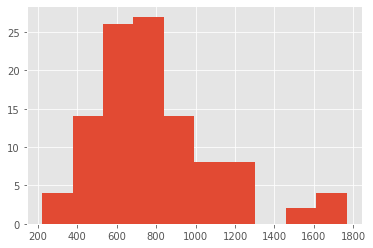

In [11]:
df['TAX'].hist()

Раз распределение похоже на нормальное, то можно заменить пропуски на среднее значение этой колонки. Для этого в pandas есть функция ```Series.fillna```, которая заменяет все пропущенные в колонке значения на заданное.

In [12]:
df['TAX'] = df['TAX'].fillna(df['TAX'].mean())

Убедимся, что все проблемы с пропусками устранены. Длина таблицы с пропусками равна длине исходного датасета.

In [13]:
len(df.dropna())

117

#### Построение модели

Теперь можно переходить непосредственно к построению модели.

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
#  Разделение на предикторы и отклик
X = df.drop('PRICE', axis=1)
y = df['PRICE']

In [16]:
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Считаем качество модели (коэффициент $R^2$).

In [17]:
print('R^2: {0}'.format(model.score(X, y)))

R^2: 0.8022436103807493


Выведем регрессионные коэффициенты от метода ```model.coef_``` и свободный член от метода ```model.intercept_```.

In [18]:
coef = pd.DataFrame(list(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist())),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,83.175919
1,SQFT,0.291978
2,FEATS,12.176743
3,NE,8.011604
4,CUST,133.014342
5,COR,-65.800841
6,TAX,0.541942


К сожалению, в ```sklearn``` не предусмотрена процедура определения статистической значимости регрессионных коэффициентов. Поэтому нужно это делать либо руками, вооружившись знанием о распределении коэффициентов, либо воспользовавшись моделью из пакета ```statsmodels```.

In [19]:
from scipy import stats

def regression_coef(model, X, y):
    coef = pd.DataFrame(list(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist())),
                    columns=['predictor', 'coef'])
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef


In [20]:
regression_coef(model, X, y)

,predictor,coef,pvalue
0,intercept,83.175919,1.895059e-01
1,SQFT,0.291978,2.580075e-06
2,FEATS,12.176743,3.419172e-01
3,NE,8.011604,8.190403e-01
4,CUST,133.014342,3.454095e-03
5,COR,-65.800841,1.168611e-01
6,TAX,0.541942,4.972770e-07


In [21]:
#  Модель по сокращенному набору предикторов

X = df[['SQFT', 'CUST', 'TAX']]
model.fit(X, y)
print('R^2: {0}'.format(model.score(X, y)))
regression_coef(model, X, y)

R^2: 0.7956603297679673


,predictor,coef,pvalue
0,intercept,99.968377,8.344463e-02
1,SQFT,0.280957,4.332654e-06
2,CUST,136.219336,2.787996e-03
3,TAX,0.588126,2.842560e-08


Как интерпретировать модель? У нас есть 3 значимых предиктора: ```SQFT```, ```CUST``` и ```TAX```.  Значение коэффициента говорит, на сколько вырастет значение сигнала при увеличении предиктора на одну единицу. Смысл первых двух коэффициентов понятен: площадь и специальный вид постройки ожидаемо влияют на цену. Но есть ли смысл включать в предсказание цены дома налог с этого же дома? Ведь налог, как и цена, также начисляется исходя из похожих предикторов. Они должны сильно коррелировать. И действительно. Построим таблицу парных корреляций предикторов.

In [22]:
df.corr()

,PRICE,SQFT,FEATS,NE,CUST,COR,TAX
PRICE,1.000000,0.844795,0.420272,0.167840,0.555292,-0.079293,0.844889
SQFT,0.844795,1.000000,0.394925,0.145030,0.520102,0.040528,0.832674
FEATS,0.420272,0.394925,1.000000,0.190016,0.241964,-0.041547,0.419473
NE,0.167840,0.145030,0.190016,1.000000,0.043033,-0.077336,0.189230
CUST,0.555292,0.520102,0.241964,0.043033,1.000000,-0.003994,0.444906
COR,-0.079293,0.040528,-0.041547,-0.077336,-0.003994,1.000000,-0.058329
TAX,0.844889,0.832674,0.419473,0.189230,0.444906,-0.058329,1.000000


Налоги сильно коррелируют с площадью. Такая проблема называется коллинеарностью. <br>
Предлагается откинуть налоги.
И начать все сначала.

In [23]:
X = df[['SQFT', 'FEATS', 'NE', 'CUST', 'COR']]
model.fit(X, y)
print('R^2: {0}'.format(model.score(X, y)))
regression_coef(model, X, y)

R^2: 0.7516955542753064


,predictor,coef,pvalue
0,intercept,73.404670,0.298398
1,SQFT,0.531621,0.000000
2,FEATS,22.777377,0.107940
3,NE,25.091290,0.519238
4,CUST,137.149425,0.006721
5,COR,-99.304860,0.032659


Часть переменных можно отбросить

In [24]:
X = df[['SQFT', 'CUST', 'COR']]
model.fit(X, y)
print('R^2: {0}'.format(model.score(X, y)))
regression_coef(model, X, y)

R^2: 0.7441272227929374


,predictor,coef,pvalue
0,intercept,127.232012,0.050080
1,SQFT,0.558295,0.000000
2,CUST,139.466327,0.006069
3,COR,-106.468045,0.022362
